In [1]:
import torch
import numpy as np
import os, json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

from evaluation_based_sampling import evaluate, evaluate_program
from daphne import daphne

from graph_based_sampling import sample_from_joint

## Problem 2
10k samples in 1.59s implies 384k samples

In [2]:
from load_helper import ast_helper, graph_helper

### Importance sampling

In [3]:
import parse
import importance_sampling
import importlib
importlib.reload(parse)

<module 'parse' from '/Users/gw/repos/prob_prog/hw/hw3/parse.py'>

In [52]:
fname = '2.daphne' 
ast = ast_helper(fname)

In [53]:
%%time
num_samples=384000
samples, sigmas = parse.take_samples(num_samples,ast=ast)


CPU times: user 10min 28s, sys: 918 ms, total: 10min 29s
Wall time: 10min 29s


In [54]:
samples = np.array([sample.tolist() for sample in samples])

In [55]:
posterior_mean, probs = importance_sampling.weighted_average(samples,sigmas,reshape_probs=(-1,1),axis=0)
posterior_mean

array([ 2.15895652, -0.53834023])

Text(0.5, 0, 'slope')

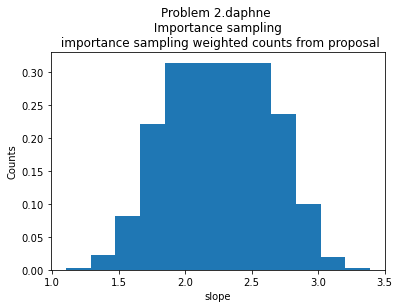

In [106]:
counts_bins = np.histogram(samples[:,0], weights=probs, bins=500)
counts, bins = counts_bins[0], counts_bins[1]
idx = (counts > counts.max()*0.005)
plt.bar(bins[1:][idx],counts[idx])
plt.title('Problem {} \n Importance sampling \n importance sampling weighted counts from proposal'.format(fname))
plt.ylabel('Counts')
plt.xlabel('slope')

Text(0.5, 0, 'bias')

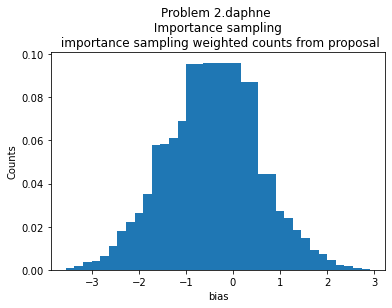

In [104]:
counts_bins = np.histogram(samples[:,1], weights=probs, bins=500)
counts, bins = counts_bins[0], counts_bins[1]
idx = (counts > counts.max()*0.005)
plt.bar(bins[1:][idx],counts[idx])
plt.title('Problem {} \n Importance sampling \n importance sampling weighted counts from proposal'.format(fname))
plt.ylabel('Counts')
plt.xlabel('bias')

In [58]:
expectation_samples_2, probs = importance_sampling.weighted_average(samples**2,sigmas,reshape_probs=(-1,1),axis=0) 
posterior_variance = expectation_samples_2 - posterior_mean**2
posterior_variance

array([0.05376331, 0.79199928])

In [59]:
expectation_samplex_sampley, probs = importance_sampling.weighted_average(samples[:,0]*samples[:,1],sigmas) 
covariance = expectation_samplex_sampley - posterior_mean[0]*posterior_mean[1]
covariance

-0.18463132614140898

In [60]:
for result in [
    "{} Importance sampling: posterior mean slope {:1.3f} | variance slope {:1.3e}".format(fname,posterior_mean[0],posterior_variance[0]),
    "{} Importance sampling: posterior mean bias {:1.3f} | variance bias {:1.3e}".format(fname,posterior_mean[1],posterior_variance[1]),
    "{} Importance sampling: posterior covariance of slope and bias variance bias {:1.3e}".format(fname,covariance),
    
]:
    print(result)

2.daphne Importance sampling: posterior mean slope 2.159 | variance slope 5.376e-02
2.daphne Importance sampling: posterior mean bias -0.538 | variance bias 7.920e-01
2.daphne Importance sampling: posterior covariance of slope and bias variance bias -1.846e-01


Numpy contains it's own method for computing this, and we can check it agrees with our results (where things are spelt out a bit more for learning purposes).

In [61]:
np.cov(samples.T,aweights=probs,ddof=0)

array([[ 0.05376331, -0.18463133],
       [-0.18463133,  0.79199928]])

### MH Gibbs
5k samples in 21.3s implies 140k samples in 10 min

In [12]:
import mh_gibbs 
from hmc import hmc_wrapper, compute_log_joint_prob
importlib.reload(mh_gibbs)

<module 'mh_gibbs' from '/Users/gw/repos/prob_prog/hw/hw3/mh_gibbs.py'>

In [13]:
fname = '2.daphne' 
graph = graph_helper(fname)
graph

[{'observe-data': ['fn',
   ['_', 'data', 'slope', 'bias'],
   ['let',
    ['xn', ['first', 'data']],
    ['let',
     ['yn', ['second', 'data']],
     ['let',
      ['zn', ['+', ['*', 'slope', 'xn'], 'bias']],
      ['let',
       ['dontcare9', ['observe', ['normal', 'zn', 1.0], 'yn']],
       ['rest', ['rest', 'data']]]]]]]},
 {'V': ['observe3',
   'observe6',
   'observe4',
   'observe7',
   'sample2',
   'sample1',
   'observe8',
   'observe5'],
  'A': {'sample2': ['observe3',
    'observe6',
    'observe4',
    'observe7',
    'observe8',
    'observe5'],
   'sample1': ['observe3',
    'observe6',
    'observe4',
    'observe7',
    'observe8',
    'observe5']},
  'P': {'sample1': ['sample*', ['normal', 0.0, 10.0]],
   'sample2': ['sample*', ['normal', 0.0, 10.0]],
   'observe3': ['observe*',
    ['normal', ['+', ['*', 'sample1', 1.0], 'sample2'], 1.0],
    2.1],
   'observe4': ['observe*',
    ['normal', ['+', ['*', 'sample1', 2.0], 'sample2'], 1.0],
    3.9],
   'observe5': ['ob

In [14]:
%%time
num_steps=140000
return_list, samples_whole_graph = mh_gibbs.mh_gibbs_wrapper(graph,num_steps)

CPU times: user 10min 14s, sys: 2.36 s, total: 10min 16s
Wall time: 10min 20s


In [15]:
samples = np.array([sample.tolist() for sample in return_list])


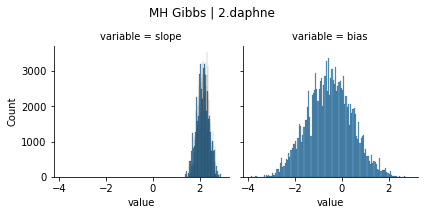

In [16]:
burn_in = int(0.01*num_steps)
df = pd.DataFrame(samples[burn_in:])
df.columns = ['slope','bias']
df['iteration'] = df.index
tall = pd.melt(df, id_vars='iteration')

g = sns.FacetGrid(tall, col="variable")
g.map(sns.histplot, "value")

plt.suptitle('MH Gibbs | {}'.format(fname))
plt.subplots_adjust(top=0.8)

In [17]:
posterior_mean = samples[burn_in:].mean(0)
cov_matrix = np.cov(samples[burn_in:].T,ddof=0)
posterior_variance = samples[burn_in:].var(0)
covariance = cov_matrix[0,1]
assert np.isclose(cov_matrix[0,0],posterior_variance[0])
assert np.isclose(cov_matrix[1,1],posterior_variance[1])

In [18]:
for result in [
    "{} MH Gibbs: posterior mean slope {:1.3f} | variance slope {:1.3e}".format(fname,posterior_mean[0],posterior_variance[0]),
    "{} MH Gibbs: posterior mean bias {:1.3f} | variance bias {:1.3e}".format(fname,posterior_mean[1],posterior_variance[1]),
    "{} MH Gibbs: posterior covariance of slope and bias variance bias {:1.3e}".format(fname,covariance),
    
]:
    print(result)

2.daphne MH Gibbs: posterior mean slope 2.149 | variance slope 5.918e-02
2.daphne MH Gibbs: posterior mean bias -0.515 | variance bias 8.965e-01
2.daphne MH Gibbs: posterior covariance of slope and bias variance bias -2.070e-01


Text(0.5, 0.98, '2.daphne | MH Gibbs \n Sample trace')

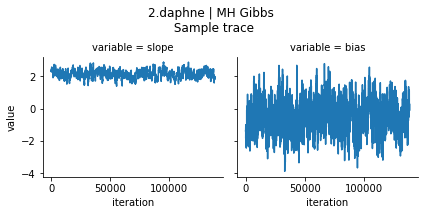

In [19]:
g = sns.FacetGrid(tall, col="variable")
g.map(plt.plot, "iteration","value")

plt.suptitle('MH Gibbs | {}'.format(fname))
plt.subplots_adjust(top=0.75)
plt.suptitle('{} | MH Gibbs \n Sample trace'.format(fname))

In [20]:
G = graph[1]
Y = G['Y']
Y = {key:evaluate([value])[0] for key,value in Y.items()}
P = G['P']

In [21]:
size = len(samples_whole_graph)
jll = np.zeros(size)
for idx in range(size):
    jll[idx] = compute_log_joint_prob(samples_whole_graph[idx],Y,P)

Text(0.5, 1.0, '2.daphne | MH Gibbs \n Joint density')

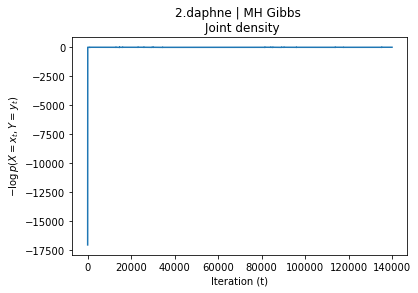

In [22]:
pd.Series(jll).plot()
plt.xlabel('Iteration (t)')
plt.ylabel(r'$-\log p(X=x_t,Y=y_t)$')
plt.title('{} | MH Gibbs \n Joint density'.format(fname))

### HMC
4.2s/ 200 samples implies 28.5k samples in 10 min 
1k samples in 21.3 s implies 28k samples

In [143]:
fname = '2.daphne' 
graph = graph_helper(fname)

In [144]:
import hmc
importlib.reload(hmc)
from hmc import hmc_wrapper

In [ ]:
num_samples=28000
return_list, samples_whole_graph = hmc_wrapper(graph,num_samples,T=20,epsilon=0.01)

In [154]:
samples = np.array([sample.tolist() for sample in return_list])

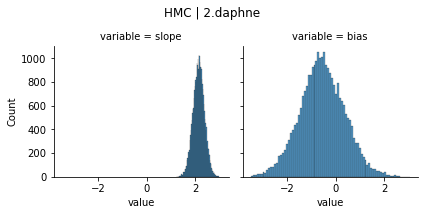

In [155]:
burn_in = int(0.01*num_samples)
df = pd.DataFrame(samples[burn_in:])
df.columns = ['slope','bias']
df['iteration'] = df.index
tall = pd.melt(df, id_vars='iteration')

g = sns.FacetGrid(tall, col="variable")
g.map(sns.histplot, "value")

plt.suptitle('HMC | {}'.format(fname))
plt.subplots_adjust(top=0.8)


In [156]:
posterior_mean = samples[burn_in:].mean(0)
cov_matrix = np.cov(samples[burn_in:].T,ddof=0)
posterior_variance = samples[burn_in:].var(0)
covariance = cov_matrix[0,1]
assert np.isclose(cov_matrix[0,0],posterior_variance[0])
assert np.isclose(cov_matrix[1,1],posterior_variance[1])

In [157]:
for result in [
    "{} HMC: posterior mean slope {:1.3f} | variance slope {:1.3e}".format(fname,posterior_mean[0],posterior_variance[0]),
    "{} HMC: posterior mean bias {:1.3f} | variance bias {:1.3e}".format(fname,posterior_mean[1],posterior_variance[1]),
    "{} HMC: posterior covariance of slope and bias variance bias {:1.3e}".format(fname,covariance),
    
]:
    print(result)

2.daphne HMC: posterior mean slope 2.161 | variance slope 5.652e-02
2.daphne HMC: posterior mean bias -0.556 | variance bias 8.609e-01
2.daphne HMC: posterior covariance of slope and bias variance bias -1.984e-01


Text(0.5, 0.98, '2.daphne | HMC \n Sample trace')

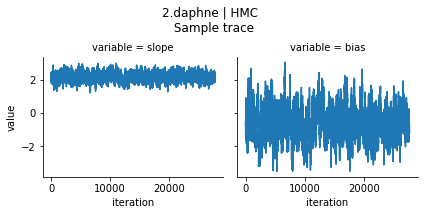

In [158]:
g = sns.FacetGrid(tall, col="variable")
g.map(plt.plot, "iteration","value")

plt.suptitle('HMC | {}'.format(fname))
plt.subplots_adjust(top=0.75)
plt.suptitle('{} | HMC \n Sample trace'.format(fname))

In [159]:
G = graph[1]
Y = G['Y']
Y = {key:evaluate([value])[0] for key,value in Y.items()}
P = G['P']

In [160]:
size = len(samples_whole_graph)
jll = np.zeros(size)
for idx in range(size):
    jll[idx] = compute_log_joint_prob(samples_whole_graph[idx],Y,P)

Text(0.5, 1.0, '2.daphne | HMC \n Joint density')

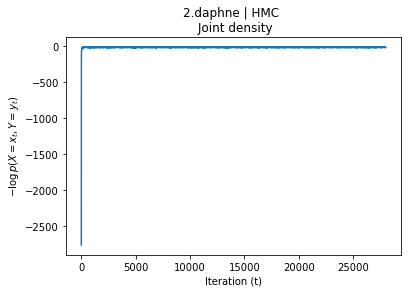

In [161]:
pd.Series(jll).plot()
plt.xlabel('Iteration (t)')
plt.ylabel(r'$-\log p(X=x_t,Y=y_t)$')
plt.title('{} | HMC \n Joint density'.format(fname))